In [1]:
from dn_utils.path import path
from os.path import join
import numpy as np
import json
import pandas as pd
from dn_utils.style import POWER_COLORS, BLUE, ORANGE
from dn_utils.networks import networks_mean
from itertools import combinations_with_replacement
from statsmodels.stats.anova import AnovaRM
from dn_utils.misc import tidy_data

In [2]:
from dn_utils.plotting import plot_matrix
%matplotlib inline

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [3]:
atlas = "combined_roi_4and5"

In [4]:
path_corrmats = join(path["bsc"], "corrmats")

# Load correlation matrices and metadata
corrmats_aggregated = np.load(
    join(path_corrmats, atlas, "corrmats_aggregated.npy"))
with open(join(path_corrmats, atlas, "corrmats_aggregated.json"), "r") as f:
    corrmats_meta = json.loads(f.read())
    
# Load subject exclusion
df_exclusion = pd.read_csv(
    join(path["nistats"], "exclusion/exclusion.csv"), index_col=0)
ok_index = df_exclusion["ok_all"]
corrmats_aggregated = corrmats_aggregated[ok_index]

# Load ROI information
df_roi = pd.read_csv(join(path_corrmats, atlas, "roi_table_filtered.csv"))
df_roi["netColor"] = df_roi["netColor"].map(POWER_COLORS)
df_roi.loc[df_roi["netName"] == "perr_inc", "netColor"] = ORANGE
df_roi.loc[df_roi["netName"] == "perr_dec", "netColor"] = BLUE

n_networks = len(df_roi["netName"].unique())
n_subjects = len(corrmats_meta["dim1"])
n_subjects_ok = sum(ok_index)
n_conditions = len(corrmats_meta["dim2"])
n_perr_sign = len(corrmats_meta["dim3"])

In [5]:
netmats_aggregated = np.zeros((n_subjects_ok, n_conditions, n_perr_sign, n_networks, n_networks))

for sub in range(n_subjects_ok):
    for con in range(n_conditions):
        for perr_sign in range(n_perr_sign):
            _, netmats_aggregated[sub, con, perr_sign] = networks_mean(
                corrmats_aggregated[sub, con, perr_sign],
                df_roi["netName"],
            )
netnames = _

In [6]:
tidy_labels = [
    pd.Series(corrmats_meta["dim1"])[ok_index].to_list(),
    corrmats_meta["dim2"],
    corrmats_meta["dim3"]
]
tidy_columns = ["sub", "con", "perr_sign"]

In [7]:
pvals = np.zeros((3, n_networks, n_networks))
fstats = np.zeros((3, n_networks, n_networks))

# Real data statistics
for i, j in combinations_with_replacement(range(n_networks), r=2):
    data = tidy_data(
        netmats_aggregated[:, :, :, i, j], 
        tidy_labels, 
        columns=tidy_columns
    )
    res = AnovaRM(
        data, 
        "depvar", 
        subject="sub", 
        within=["con", "perr_sign"]
    ).fit()
    
    # Store F statistic and p-values
    fstats[:, i, j] = res.anova_table["F Value"]
    pvals[:, i, j] = res.anova_table["Pr > F"]

# np.save(join(path_corrmats_unthr_gamma, "d_fstats.npy"), fstats)
# np.save(join(path_corrmats_unthr_gamma, "d_pvals.npy"), pvals)

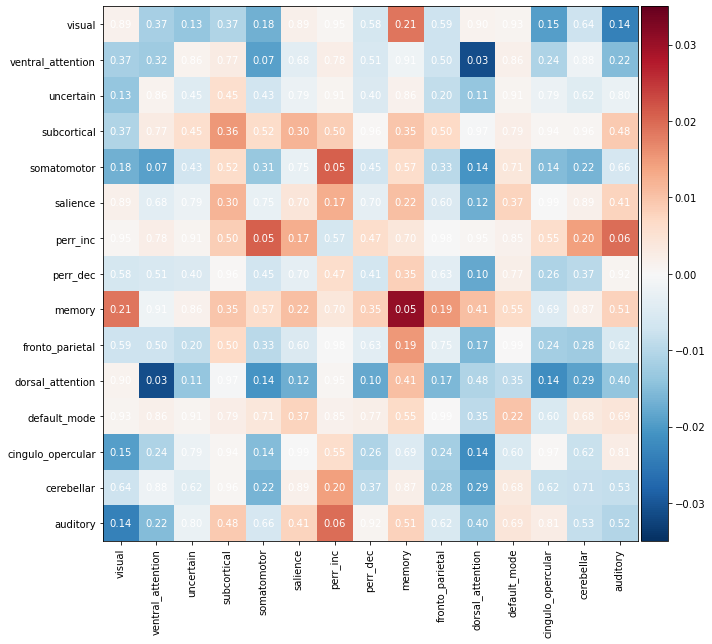

In [24]:
p = pvals[1]
p = p + np.tril(p.T, k=-1)

mat = np.mean(netmats_aggregated, axis=(0, 1))[0] - np.mean(netmats_aggregated, axis=(0, 1))[1] 

plot_matrix(mat, clim=[-.035, .035], labels=netnames, annotate=p)

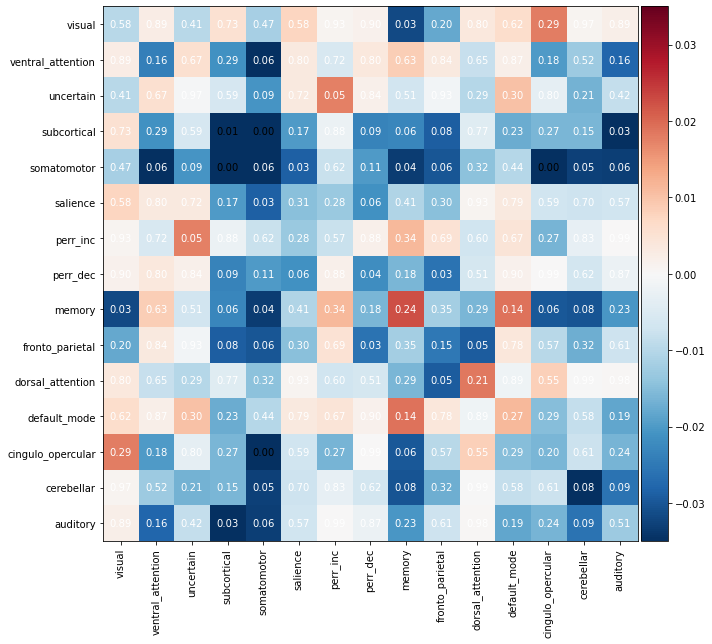

In [25]:
p = pvals[0]
p = p + np.tril(p.T, k=-1)

mat = np.mean(netmats_aggregated, axis=(0, 2))[0] - np.mean(netmats_aggregated, axis=(0, 2))[1] 

plot_matrix(mat, clim=[-.035, .035], labels=netnames, annotate=p)

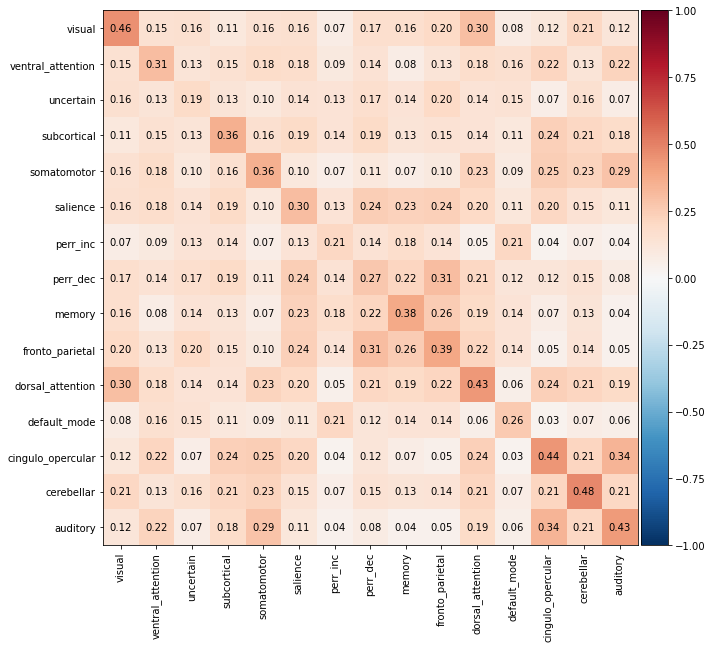

In [26]:
mat = np.mean(netmats_aggregated, axis=(0, 1, 2))

plot_matrix(mat, labels=netnames, annotate=mat)

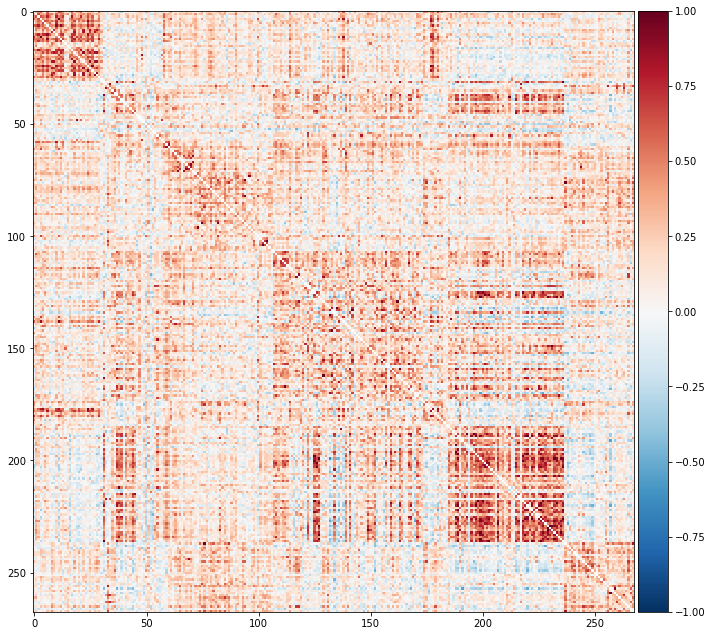

In [27]:
plot_matrix(corrmats_aggregated[0,0,0])